Epoch 1/30
1500/1500 - 4s - loss: 0.2378 - accuracy: 0.9257 - val_loss: 0.0816 - val_accuracy: 0.9743
Epoch 2/30
1500/1500 - 4s - loss: 0.0750 - accuracy: 0.9765 - val_loss: 0.0779 - val_accuracy: 0.9758
Epoch 3/30
1500/1500 - 4s - loss: 0.0550 - accuracy: 0.9831 - val_loss: 0.0539 - val_accuracy: 0.9836
Epoch 4/30
1500/1500 - 4s - loss: 0.0412 - accuracy: 0.9866 - val_loss: 0.0519 - val_accuracy: 0.9850
Epoch 5/30
1500/1500 - 4s - loss: 0.0341 - accuracy: 0.9897 - val_loss: 0.0491 - val_accuracy: 0.9853
Epoch 6/30
1500/1500 - 4s - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.0423 - val_accuracy: 0.9879
Epoch 7/30
1500/1500 - 4s - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.0445 - val_accuracy: 0.9865
Epoch 8/30
1500/1500 - 4s - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0439 - val_accuracy: 0.9873
Epoch 9/30
1500/1500 - 4s - loss: 0.0166 - accuracy: 0.9945 - val_loss: 0.0445 - val_accuracy: 0.9885
Epoch 10/30
1500/1500 - 5s - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.0426 - 

C:\Users\tsans\anaconda3\envs\py363\lib\site-packages\ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\tsans\anaconda3\envs\py363\lib\site-packages\ipykernel_launcher.py:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


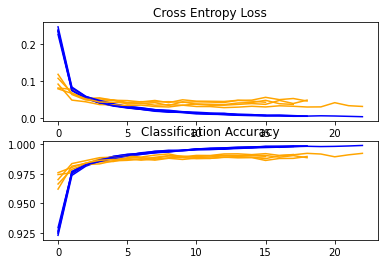

Accuracy: mean=98.935 std=0.142, n=5


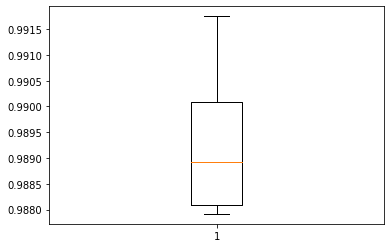

In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
    
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.1))
	model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		estp = EarlyStopping(monitor='val_loss', min_delta=0.0005,patience=10, verbose=1, mode='auto',restore_best_weights=True)
		history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=(testX, testY), verbose=2, callbacks=[estp])
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
	return scores, histories
    
 
# entry point, run the test harness
scores,histories = run_test_harness()

In [2]:
import numpy as np
vl0=histories[0].history['val_loss']
vl0=np.array(vl0[0:13])

In [3]:
vl1=histories[1].history['val_loss']
vl1=np.array(vl1[0:13])

In [4]:
vl2=histories[2].history['val_loss']
vl2=np.array(vl2[0:13])

In [5]:
vl3=histories[3].history['val_loss']
vl3=np.array(vl3[0:13])

In [6]:
vl4=histories[4].history['val_loss']
vl4=np.array(vl4[0:13])

In [7]:
vlavg=[np.mean(k) for k in zip(vl0,vl1,vl2,vl3,vl4)]

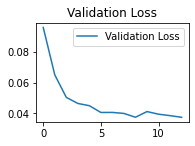

In [8]:
pyplot.subplot(2, 2, 2)
pyplot.plot(vlavg, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Validation Loss')
pyplot.show()

In [9]:
# plot diagnostic learning curves
def summarize_diagnostics2(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, figsize=(15,15))
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='training loss')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='validation loss')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

In [11]:
scores2=[]
histories2=[]
model = define_model()
trainX, trainY, testX, testY = load_dataset()

trainX, testX = prep_pixels(trainX, testX)

estp = EarlyStopping(monitor='val_loss', min_delta=0.0005,patience=10, verbose=1, mode='auto',restore_best_weights=True)
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.1, verbose=2, callbacks=[estp])
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print(' ')
print('Accuracy on Test Set -> %.3f' % (acc * 100.0))
# stores scores
scores2.append(acc)
histories2.append(history)

Epoch 1/30
1688/1688 - 5s - loss: 0.2235 - accuracy: 0.9302 - val_loss: 0.1070 - val_accuracy: 0.9695
Epoch 2/30
1688/1688 - 4s - loss: 0.0737 - accuracy: 0.9772 - val_loss: 0.0546 - val_accuracy: 0.9842
Epoch 3/30
1688/1688 - 4s - loss: 0.0537 - accuracy: 0.9832 - val_loss: 0.0467 - val_accuracy: 0.9868
Epoch 4/30
1688/1688 - 4s - loss: 0.0408 - accuracy: 0.9869 - val_loss: 0.0483 - val_accuracy: 0.9857
Epoch 5/30
1688/1688 - 4s - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0462 - val_accuracy: 0.9868
Epoch 6/30
1688/1688 - 5s - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.0352 - val_accuracy: 0.9913
Epoch 7/30
1688/1688 - 5s - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0310 - val_accuracy: 0.9918
Epoch 8/30
1688/1688 - 5s - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.0350 - val_accuracy: 0.9902
Epoch 9/30
1688/1688 - 4s - loss: 0.0183 - accuracy: 0.9936 - val_loss: 0.0375 - val_accuracy: 0.9902
Epoch 10/30
1688/1688 - 4s - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0367 - 

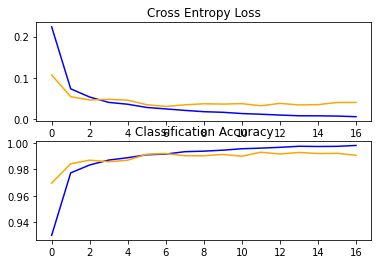

In [12]:
summarize_diagnostics(histories2)

In [13]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)              